# Object Classification

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# import library
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras import models, layers, utils, backend
from tensorflow.keras import losses, metrics, optimizers
from tensorflow.keras.preprocessing import image

from sklearn.metrics import classification_report, confusion_matrix

from matplotlib import pyplot as plt

import numpy as np
import os

In [3]:
# parameter yang digunakan
img_size = (299, 299, 3)
dir_img_train = "dataset/subset/train/"
dir_img_validation = "dataset/subset/validation/"
dir_img_test = "dataset/subset/test/"
batch_size = 16

lr_classifier = 1e-4
epoch_classifier = 10

# learning rate untuk fine tuning perlu diset kecil agar tidak merusak bobot yang sudah terbentuk
lr_tuning = 1e-6
epoch_tuning = 12

## Prepare Dataset

Dataset umumnya akan dilakukan augmentasi dan normalisasi nilai citra masukan. Perintah `rescale = 1. / 255` akan menormalisasi nilai citra masukan dari rentang 0 sampai 255 menjadi rentang 0 sampai 1.

In [4]:
train_datagen = image.ImageDataGenerator(
    # rescale=1. / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest")

# Note that the validation data should not be augmented!
test_datagen = image.ImageDataGenerator(
    # rescale=1. / 255
)

In [5]:
train_generator = train_datagen.flow_from_directory(
    # target folder yang berisi kumpulan citra
    dir_img_train,
    # semua citra diubah ukurannya menjadi 299 x 299
    target_size=img_size[:2],
    batch_size=batch_size,
    # class_mode categorical harus disesuaikan dengan fungsi loss
    # Karena fungsi loss yang digunakan adalah categorical crossentropy
    # maka class_mode = categorical
    class_mode="categorical",
    shuffle=True,
    seed=1234)

validation_generator = test_datagen.flow_from_directory(
    dir_img_validation,
    target_size=img_size[:2],
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    seed=1234)

test_generator = test_datagen.flow_from_directory(dir_img_test,
                                                  target_size=img_size[:2],
                                                  batch_size=batch_size,
                                                  class_mode="categorical",
                                                  shuffle=True,
                                                  seed=1234)

Found 12000 images belonging to 12 classes.
Found 1200 images belonging to 12 classes.
Found 1200 images belonging to 12 classes.


Pada model transfer learning disediakan [preprocess_input](https://www.tensorflow.org/versions/r2.1/api_docs/python/tf/keras/applications/xception). Mari kita lihat apa yang `preprocess_input` lakukan

In [6]:
im_list = os.listdir(os.path.join(dir_img_train, "bicycle_final"))
im_list[:3]

['221703183553_2.JPG', '121711853324_5.JPG', '231576433314_9.JPG']

In [7]:
fpath = os.path.join(dir_img_train, "bicycle_final/221703183553_2.JPG")

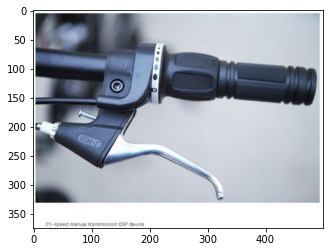

In [8]:
im = image.load_img(fpath)
plt.imshow(im)

In [9]:
im_array = image.img_to_array(im)
im_array.min(), im_array.max(), im_array.mean()

(0.0, 255.0, 171.3353)

In [10]:
preprocess_input(im_array)
im_array.min(), im_array.max(), im_array.mean()

(-1.0, 1.0, 0.34380642)

### Take away:

1. [Kenali normalisasi model pre-trained:](https://github.com/keras-team/keras-applications/tree/master/keras_applications)
    - caffe: will convert the images from RGB to BGR, then will zero-center each color channel with respect to the ImageNet dataset, without scaling. Contoh model : vgg, resnet, resnet50
    - tf: will scale pixels between -1 and 1, sample-wise. Contoh model : inception, xception, mobilenet, nasnet, resnet_v2
    - torch: will scale pixels between 0 and 1 and then will normalize each channel with respect to the ImageNet dataset. Contoh model : densenet, efficientnet, resnext
   
   
2. Pengalaman pribadi pada model Inception / Xception dengan metode `rescale=1./255` dibandingkan `preprocess_input` tidak memberikan dampak yang signifikan terhadap model. Pilih salah satu, apakah gunakan `preprocess_input`, atau `rescale = 1. / 255`, jangan keduanya.

Pada sesi kali ini saya akan gunakan `preprocess_input`.

## Cek Training Dataset

In [11]:
train_generator[0][0].shape

(16, 299, 299, 3)

In [12]:
image_idx = train_generator.index_array[1]
train_generator.labels[image_idx]

7

In [13]:
fname = train_generator.filenames[image_idx]
fname

'mug_final/231638892622_2.JPG'

In [14]:
train_images_7, train_labels_7 = train_generator[7]
print(train_images_7.shape)
print(train_labels_7.shape)

(16, 299, 299, 3)
(16, 12)


<function matplotlib.pyplot.show(close=None, block=None)>

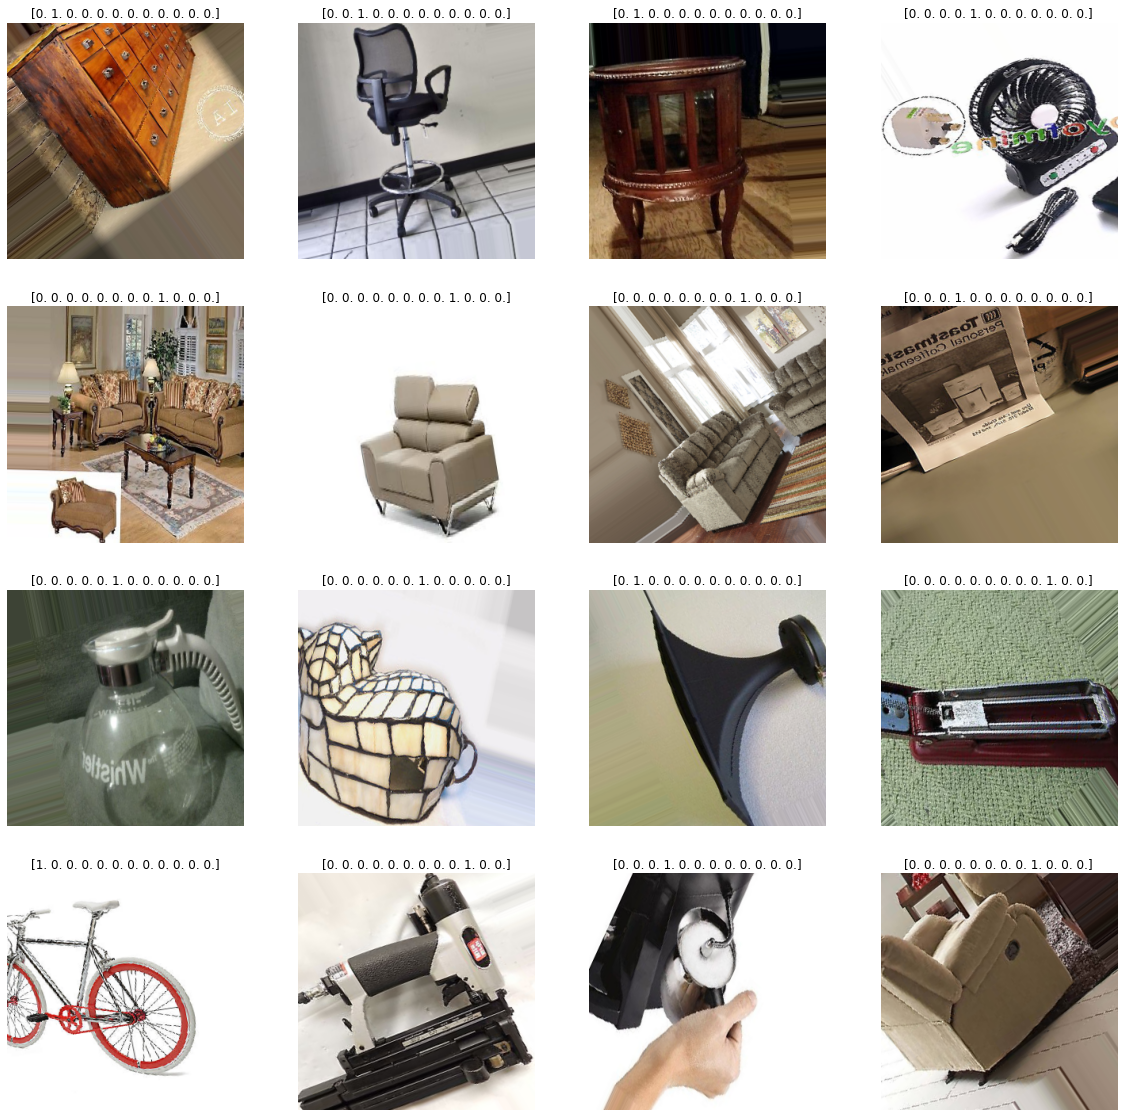

In [15]:
plt.figure(figsize=(20, 20))

for idx in range(16):
    ax = plt.subplot(4, 4, idx + 1)
    plt.imshow(image.array_to_img(train_images_7[idx]))
    plt.title(str(train_labels_7[idx]))
    plt.axis('off')

plt.show

## Cek Validation Dataset

In [16]:
validation_generator[0][0].shape

(16, 299, 299, 3)

In [17]:
image_idx = validation_generator.index_array[1]
validation_generator.labels[image_idx]

11

In [18]:
fname = validation_generator.filenames[image_idx]
fname

'toaster_final/171880597038_6.JPG'

In [19]:
validation_images_7, validation_labels_7 = validation_generator[7]
print(validation_images_7.shape)
print(validation_labels_7.shape)

(16, 299, 299, 3)
(16, 12)


<function matplotlib.pyplot.show(close=None, block=None)>

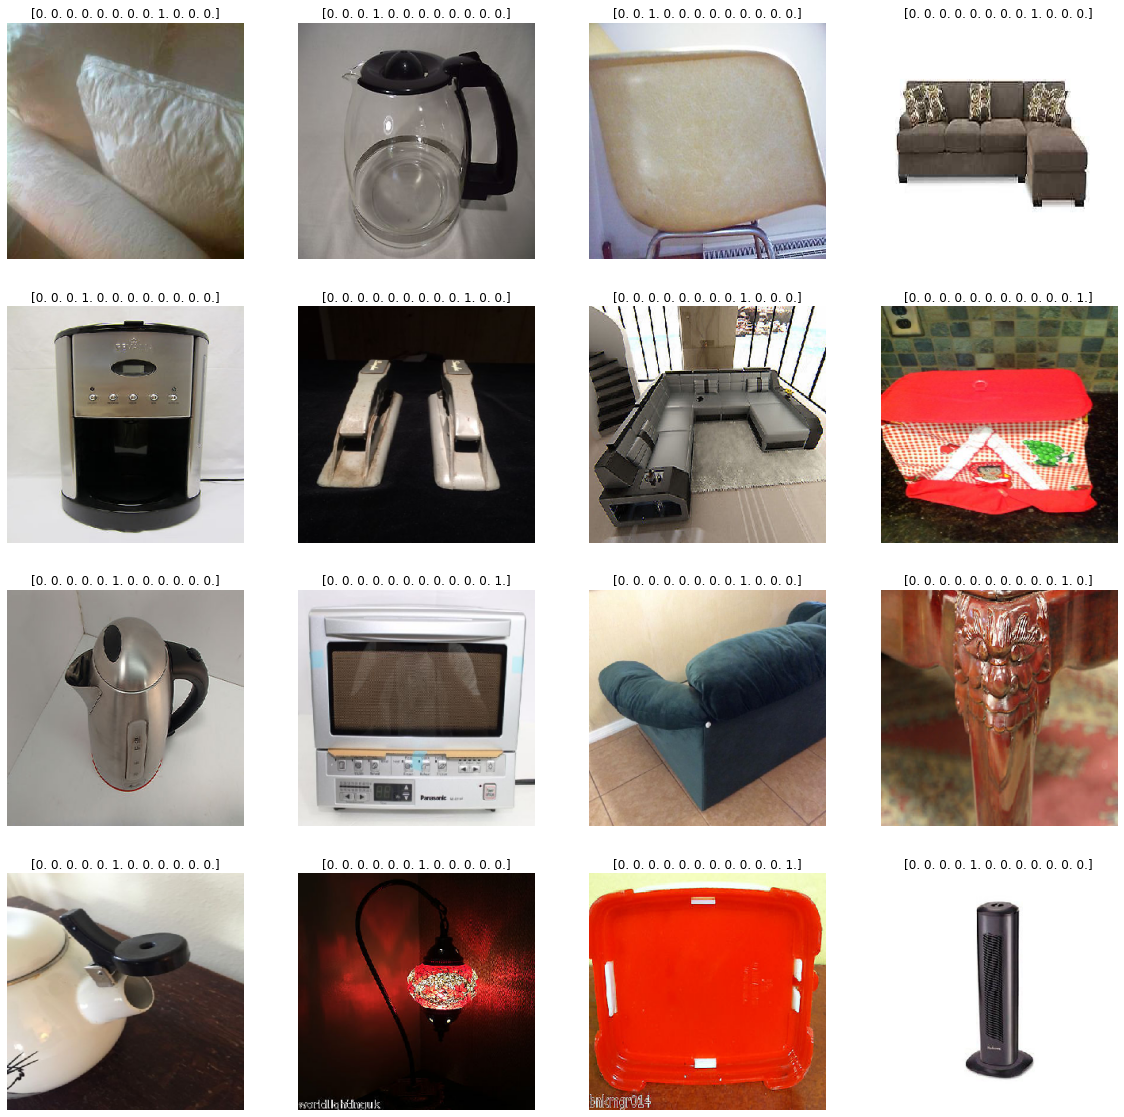

In [20]:
plt.figure(figsize=(20, 20))

for idx in range(16):
    ax = plt.subplot(4, 4, idx + 1)
    plt.imshow(image.array_to_img(validation_images_7[idx]))
    plt.title(str(validation_labels_7[idx]))
    plt.axis('off')

plt.show

## Cek Test Dataset

In [21]:
test_generator[0][0].shape

(16, 299, 299, 3)

In [22]:
image_idx = test_generator.index_array[1]
test_generator.labels[image_idx]

11

In [23]:
fname = test_generator.filenames[image_idx]
fname

'toaster_final/190997089605_1.JPG'

In [24]:
test_images_7, test_labels_7 = test_generator[7]
print(test_images_7.shape)
print(test_labels_7.shape)

(16, 299, 299, 3)
(16, 12)


<function matplotlib.pyplot.show(close=None, block=None)>

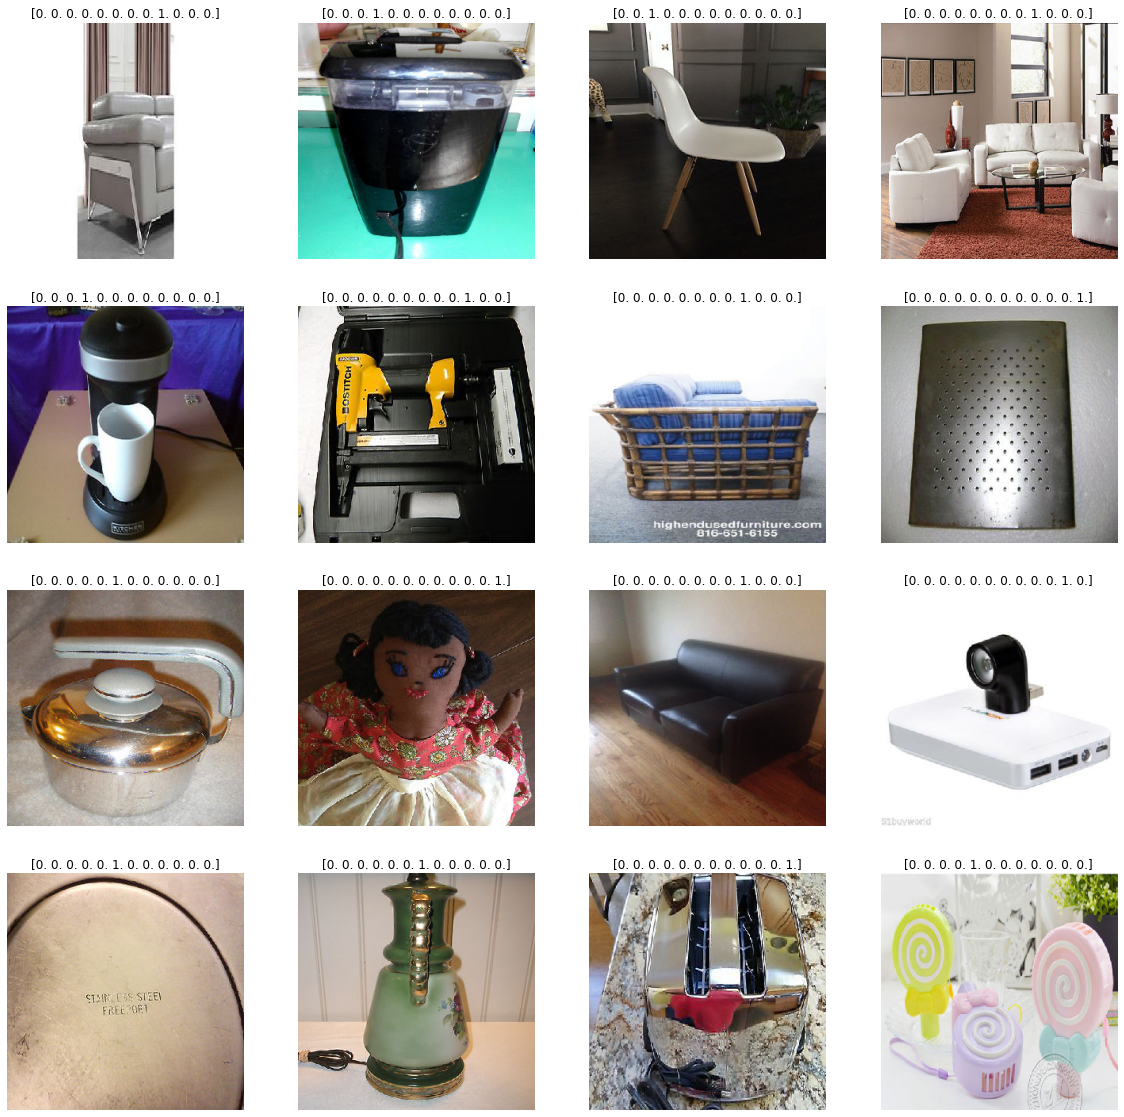

In [25]:
plt.figure(figsize=(20, 20))

for idx in range(16):
    ax = plt.subplot(4, 4, idx + 1)
    plt.imshow(image.array_to_img(test_images_7[idx]))
    plt.title(str(test_labels_7[idx]))
    plt.axis('off')

plt.show

## Define Classifier Architecture

Pada bagian ini kita akan mendefinisikan susunan arsitektur yang digunakan. Bagian convolution akan menggunakan arsitektur Xception. Sedangkan bagian classifier bisa kita custom ataupun mengikuti arsitektur yang framework Keras sudah sediakan.

In [26]:
strategy = tf.distribute.MirroredStrategy()
print("Number of devices: {}".format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


### Keras Classifier

In [27]:
def create_model_keras():
    conv_base = Xception(weights="imagenet",
                         include_top=False,
                         input_shape=img_size)

    conv_base.trainable = False

    input_layer = keras.Input(shape=img_size)
    x = preprocess_input(input_layer)
    x = conv_base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    output_layer = layers.Dense(12, activation="softmax")(x)

    model = keras.Model(inputs=input_layer, outputs=output_layer)

    return conv_base, model

In [28]:
try:
    del (conv_base)
    del (model)
except:
    pass

backend.clear_session()

# Open a strategy scope.
with strategy.scope():
    # Everything that creates variables should be under the strategy scope.
    # In general this is only model construction & `compile()`.
    conv_base, model = create_model_keras()
    model.compile(loss=losses.CategoricalCrossentropy(),
                  optimizer=optimizers.Adam(learning_rate=lr_classifier),
                  metrics=[metrics.CategoricalAccuracy()])

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [29]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
tf_op_layer_truediv (TensorF [(None, 299, 299, 3)]     0         
_________________________________________________________________
tf_op_layer_sub (TensorFlowO [(None, 299, 299, 3)]     0         
_________________________________________________________________
xception (Model)             (None, 10, 10, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 12)                24588     
Total params: 20,886,068
Trainable params: 24,588
Non-trainable params: 20,861,480
____________________________________________

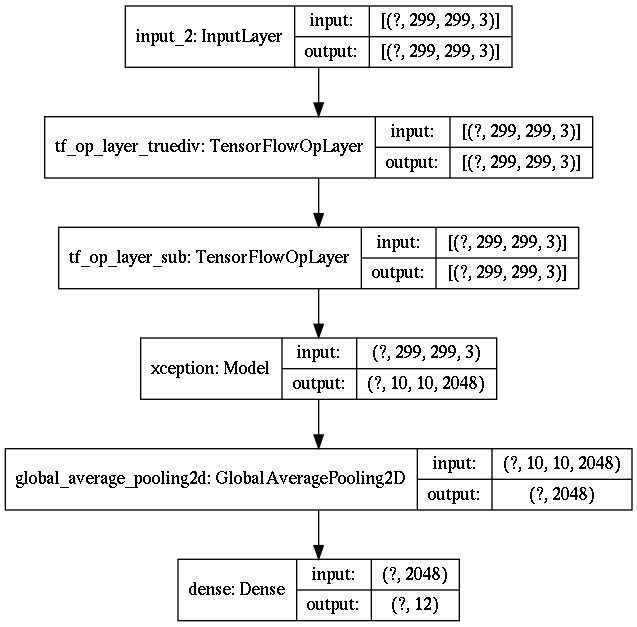

In [30]:
utils.plot_model(model, show_layer_names=True, show_shapes=True)

### Fastai classifier

In [31]:
def create_model_fastai():
    conv_base = Xception(weights="imagenet",
                         include_top=False,
                         input_shape=img_size)

    conv_base.trainable = False

    input_layer = keras.Input(shape=img_size)
    x = preprocess_input(input_layer)
    x = conv_base(x, training=False)
    x1 = layers.GlobalAveragePooling2D()(x)
    x2 = layers.GlobalMaxPooling2D()(x)
    x = layers.Concatenate()([x1, x2])
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    output_layer = layers.Dense(12, activation="softmax")(x)

    model = keras.Model(inputs=input_layer, outputs=output_layer)

    return conv_base, model

In [32]:
try:
    del (conv_base)
    del (model)
except:
    pass

backend.clear_session()

# Open a strategy scope.
with strategy.scope():
    # Everything that creates variables should be under the strategy scope.
    # In general this is only model construction & `compile()`.
    conv_base, model = create_model_fastai()
    model.compile(loss=losses.CategoricalCrossentropy(),
                  optimizer=optimizers.Adam(learning_rate=lr_classifier),
                  metrics=[metrics.CategoricalAccuracy()])

In [33]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv (TensorFlow [(None, 299, 299, 3) 0           input_2[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_sub (TensorFlowOpLa [(None, 299, 299, 3) 0           tf_op_layer_truediv[0][0]        
__________________________________________________________________________________________________
xception (Model)                (None, 10, 10, 2048) 20861480    tf_op_layer_sub[0][0]            
______________________________________________________________________________________________

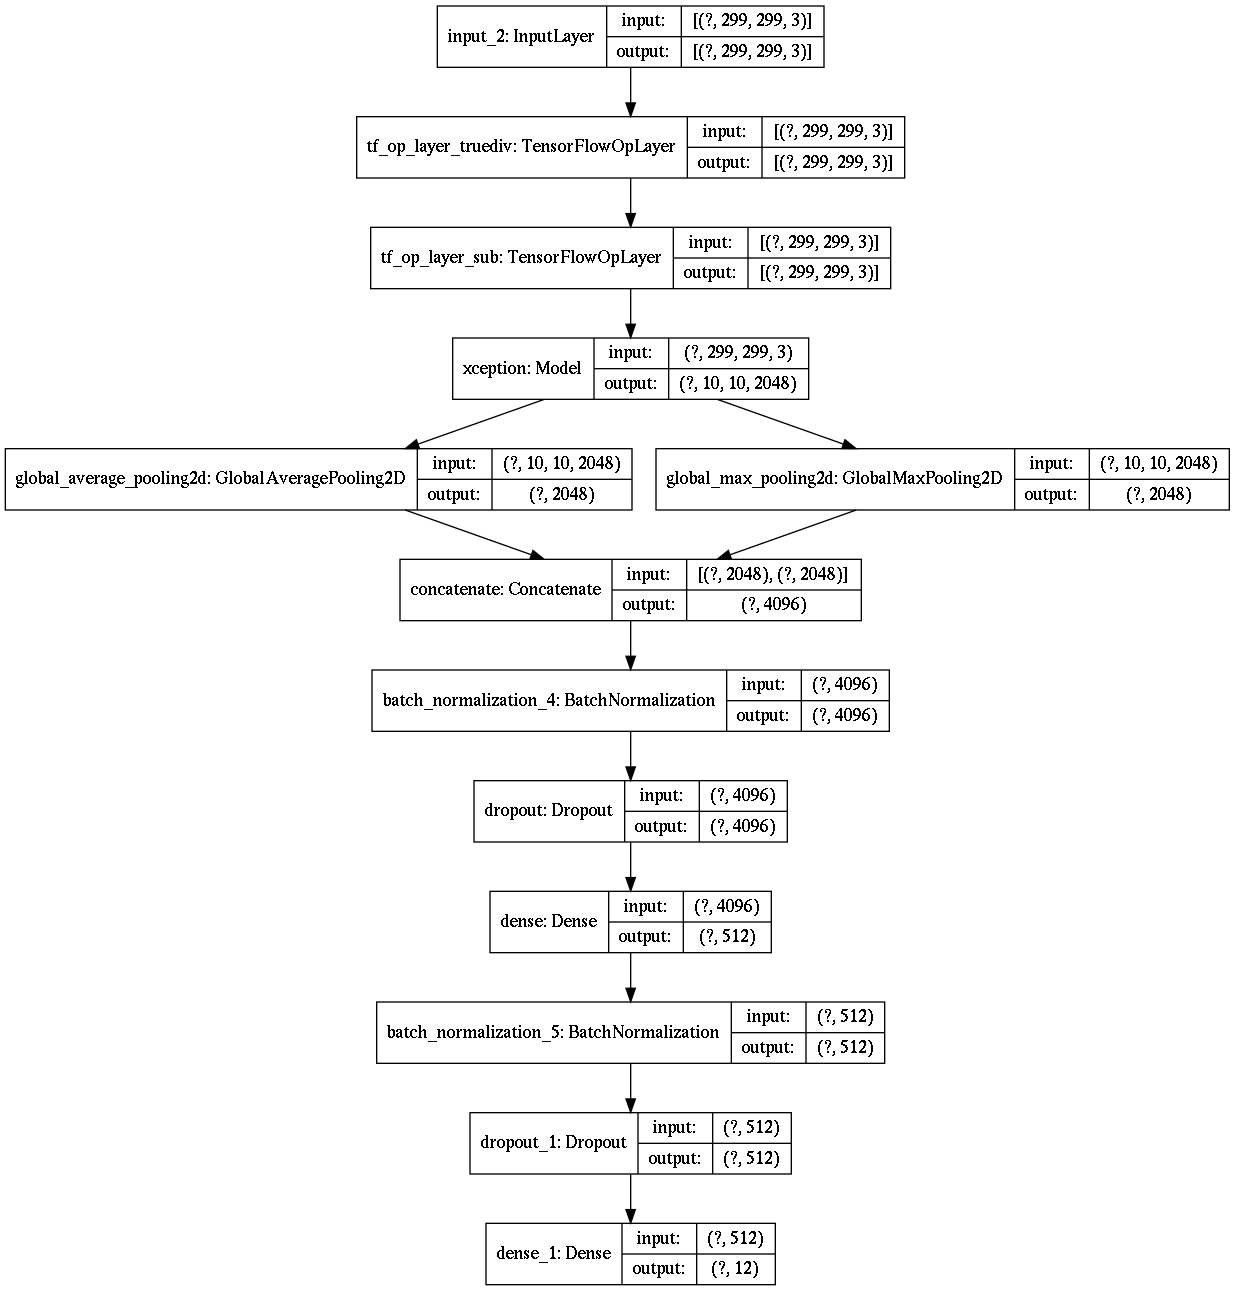

In [34]:
utils.plot_model(model, show_layer_names=True, show_shapes=True)

### Sazzad classifier

In [35]:
# sumber: https://dl.acm.org/doi/10.1145/3377049.3377067
def create_model_sazzad():
    conv_base = Xception(weights="imagenet",
                         include_top=False,
                         input_shape=img_size)

    conv_base.trainable = False

    input_layer = keras.Input(shape=img_size)
    x = preprocess_input(input_layer)
    x = conv_base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(1024, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    output_layer = layers.Dense(12, activation="softmax")(x)

    model = keras.Model(inputs=input_layer, outputs=output_layer)

    return conv_base, model

In [36]:
try:
    del (conv_base)
    del (model)
except:
    pass

backend.clear_session()

# Open a strategy scope.
with strategy.scope():
    # Everything that creates variables should be under the strategy scope.
    # In general this is only model construction & `compile()`.
    conv_base, model = create_model_sazzad()
    model.compile(loss=losses.CategoricalCrossentropy(),
                  optimizer=optimizers.Adam(learning_rate=lr_classifier),
                  metrics=[metrics.CategoricalAccuracy()])

In [37]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
tf_op_layer_truediv (TensorF [(None, 299, 299, 3)]     0         
_________________________________________________________________
tf_op_layer_sub (TensorFlowO [(None, 299, 299, 3)]     0         
_________________________________________________________________
xception (Model)             (None, 10, 10, 2048)      20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              209817

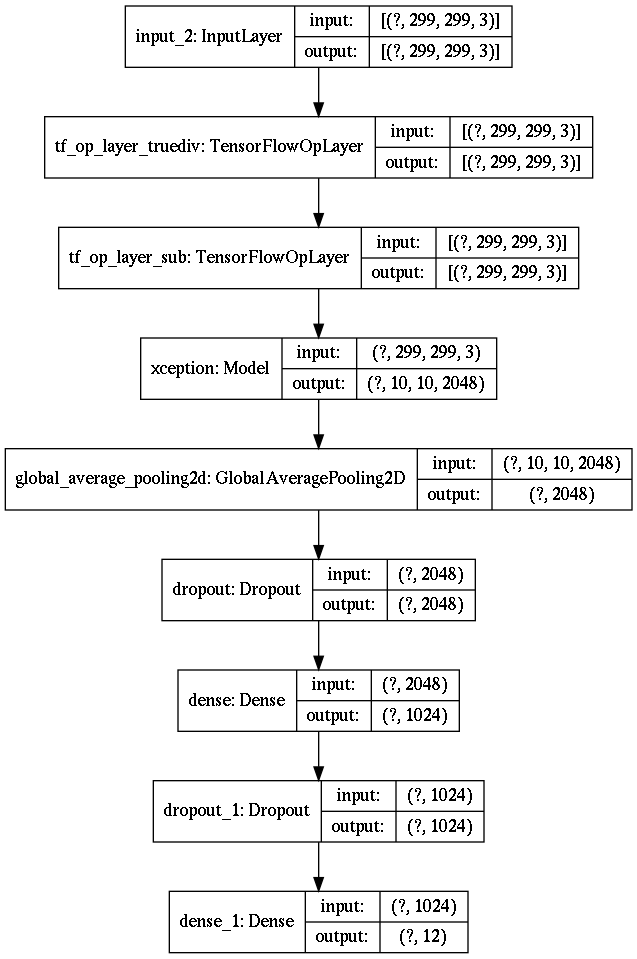

In [38]:
utils.plot_model(model, show_layer_names=True, show_shapes=True)

### Take away: 

Q : Bagaimana memilih arsitektur classifier?

A : Bisa pakai arsitektur classifier bawaan dari Keras / framework lain seperti fastai. Bisa juga ikuti arsitektur yang dipakai pada jurnal-jurnal sesuai studi yang sedang dilakukan.

Pada sesi kali ini saya akan menggunakan classifier fastai

In [39]:
try:
    del (conv_base)
    del (model)
except:
    pass

backend.clear_session()

# Open a strategy scope.
with strategy.scope():
    # Everything that creates variables should be under the strategy scope.
    # In general this is only model construction & `compile()`.
    conv_base, model = create_model_fastai()
    model.compile(loss=losses.CategoricalCrossentropy(),
                  optimizer=optimizers.Adam(learning_rate=lr_classifier),
                  metrics=[metrics.CategoricalAccuracy()])

In [40]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv (TensorFlow [(None, 299, 299, 3) 0           input_2[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_sub (TensorFlowOpLa [(None, 299, 299, 3) 0           tf_op_layer_truediv[0][0]        
__________________________________________________________________________________________________
xception (Model)                (None, 10, 10, 2048) 20861480    tf_op_layer_sub[0][0]            
______________________________________________________________________________________________

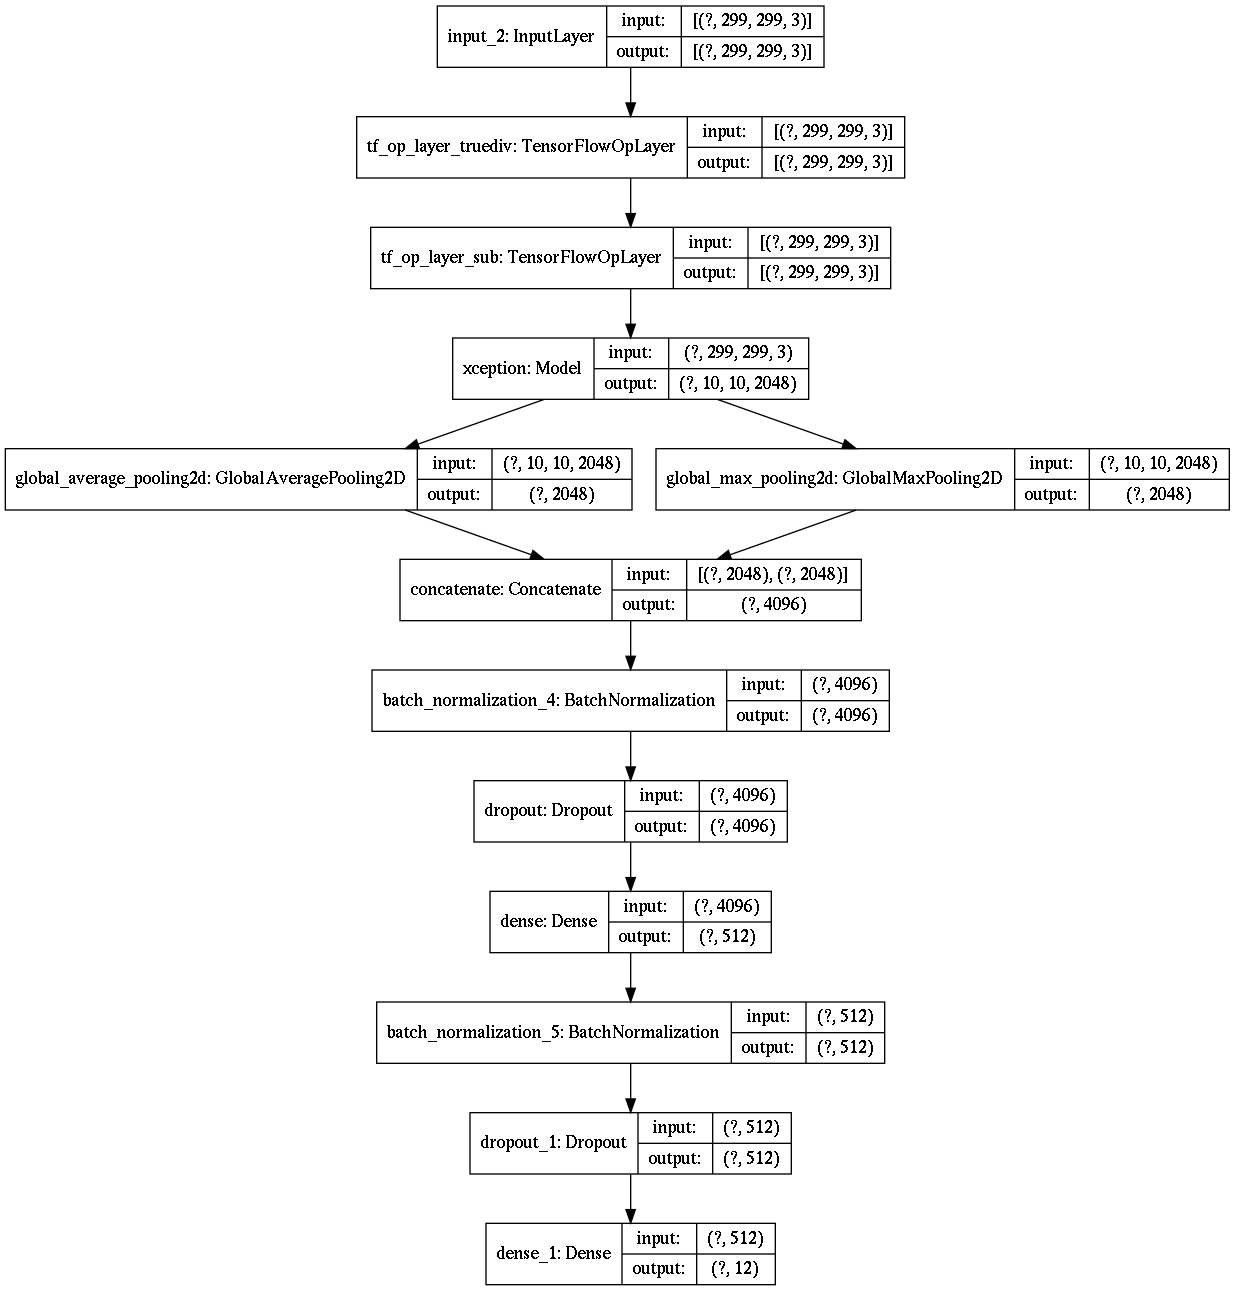

In [41]:
utils.plot_model(model, show_layer_names=True, show_shapes=True)

## Training Clasifier

In [42]:
%%time
history = model.fit(train_generator,
                    epochs=epoch_classifier,
                    validation_data=validation_generator,
                    verbose=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 750 steps, validate for 75 steps
Epoch 1/10
750/750 [==============================] - 172s 229ms/step - loss: 1.6030 - categorical_accuracy: 0.5571 - val_loss: 0.7213 - val_categorical_accuracy: 0.7767
Epoch 2/10
750/750 [==============================] - 163s 217ms/step - loss: 1.2363 - categorical_accuracy: 0.6501 - val_loss: 0.6812 - val_categorical_accuracy: 0.7808
Epoch 3/10
750/750 [==============================] - 163s 217ms/step - loss: 1.1056 - categorical_accuracy: 0.6755 - val_loss: 0.6555 - val_categorical_accuracy: 0.7792
Epoch 4/10
750/750 [==============================] - 163s 217ms/step - loss: 1.0204 - categorical_accuracy: 0.6918 - val_loss: 0.6320 - val_categorical_accuracy: 0.7842
Epoch 5/10
750/750 [==============================] - 163s 217ms/step - loss: 0.9700 - categorical_accuracy: 0.6975 - val_loss: 0.6194 - val_categorical_accuracy: 0.7950
Epoch 6/10
750/750 [==============================] - 163

In [43]:
model.metrics_names

['loss', 'categorical_accuracy']

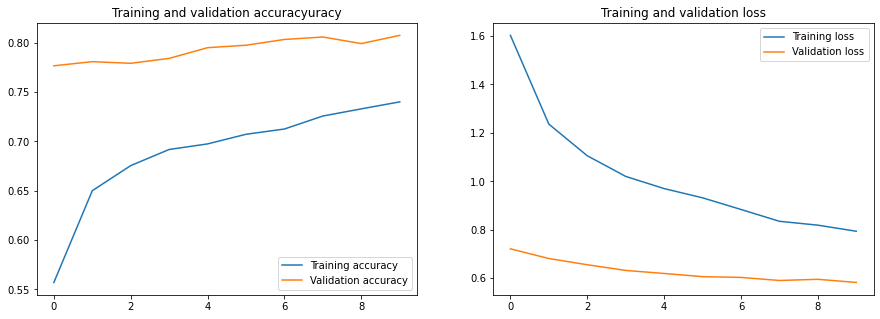

In [44]:
accuracy = history.history['categorical_accuracy']
val_accuracy = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracyuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Evaluate Model

In [45]:
model.evaluate(test_generator, verbose=1)

  ...
    to  
  ['...']
75/75 [==============================] - 10s 133ms/step - loss: 0.6193 - categorical_accuracy: 0.8083


[0.6193091050783793, 0.80833334]

In [46]:
y_true = list()
for idx in range(len(test_generator.index_array)):
    img_idx = test_generator.index_array[idx]
    y_true.append(test_generator.labels[img_idx])

In [47]:
y_pred_prob = model.predict(test_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

75/75 [==============================] - 10s 129ms/step


In [48]:
print(
    classification_report(y_true,
                          y_pred,
                          target_names=[
                              'bicycle', 'cabinet', 'chair', 'coffe_maker',
                              'fan', 'kettle', 'lamp', 'mug', 'sofa',
                              'stapler', 'table', 'toaster'
                          ]))

              precision    recall  f1-score   support

     bicycle       0.98      0.98      0.98       100
     cabinet       0.79      0.83      0.81       100
       chair       0.75      0.67      0.71       100
 coffe_maker       0.78      0.82      0.80       100
         fan       0.85      0.84      0.84       100
      kettle       0.81      0.88      0.84       100
        lamp       0.75      0.75      0.75       100
         mug       0.85      0.90      0.87       100
        sofa       0.85      0.90      0.87       100
     stapler       0.80      0.86      0.83       100
       table       0.69      0.57      0.62       100
     toaster       0.77      0.70      0.73       100

    accuracy                           0.81      1200
   macro avg       0.81      0.81      0.81      1200
weighted avg       0.81      0.81      0.81      1200



In [49]:
model.save("transfer_learning_classifier.h5")

## Fine tuning

In [50]:
conv_base.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [51]:
conv_base.trainable = True

# set_trainable = False
# for layer in conv_base.layers:
#     if layer.name == 'add_7':
#         set_trainable = True

#     if set_trainable:
#         layer.trainable = True
#     else:
#         layer.trainable = False

In [52]:
with strategy.scope():
    model.compile(optimizer=optimizers.Adam(learning_rate=lr_tuning),
                  loss=losses.CategoricalCrossentropy(),
                  metrics=[metrics.CategoricalAccuracy()])

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
tf_op_layer_truediv (TensorFlow [(None, 299, 299, 3) 0           input_2[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_sub (TensorFlowOpLa [(None, 299, 299, 3) 0           tf_op_layer_truediv[0][0]        
__________________________________________________________________________________________________
xception (Model)                (None, 10, 10, 2048) 20861480    tf_op_layer_sub[0][0]            
______________________________________________________________________________________________

In [53]:
%%time
history = model.fit(train_generator,
                    epochs=epoch_tuning,
                    validation_data=validation_generator,
                    verbose=1)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 750 steps, validate for 75 steps
Epoch 1/12
750/750 [==============================] - 434s 579ms/step - loss: 0.7447 - categorical_accuracy: 0.7532 - val_loss: 0.5779 - val_categorical_accuracy: 0.8125
Epoch 2/12
750/750 [==============================] - 430s 573ms/step - loss: 0.7200 - categorical_accuracy: 0.7582 - val_loss: 0.5751 - val_categorical_accuracy: 0.8125
Epoch 3/12
750/750 [==============================] - 432s 576ms/step - loss: 0.7096 - categorical_accuracy: 0.7598 - val_loss: 0.5693 - val_categorical_accuracy: 0.8142
Epoch 4/12
750/750 [==============================] - 431s 574ms/step - loss: 0.6999 - categorical_accuracy: 0.7658 - val_loss: 0.5645 - val_categorical_accuracy: 0.8150
Epoch 5/12
750/750 [==============================] - 432s 576ms/step - loss: 0.6953 - categorical_accuracy: 0.7657 - val_loss: 0.5596 - val_categorical_accuracy: 0.8183
Epoch 6/12
750/750 [==============================] - 431

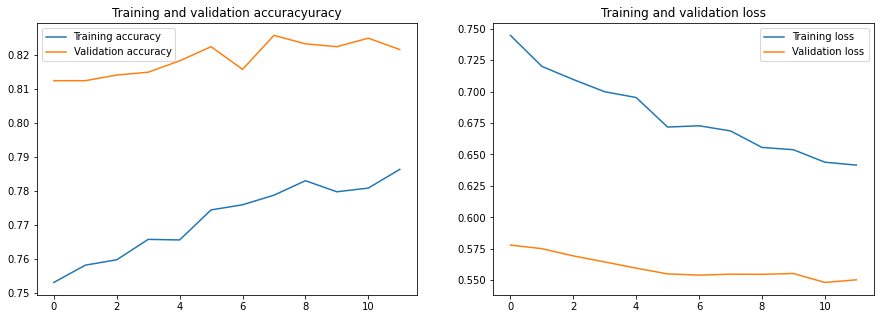

In [54]:
accuracy = history.history['categorical_accuracy']
val_accuracy = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, label='Training accuracy')
plt.plot(epochs, val_accuracy, label='Validation accuracy')
plt.title('Training and validation accuracyuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### Evaluate Model

In [55]:
model.evaluate(test_generator, verbose=1)

  ...
    to  
  ['...']
75/75 [==============================] - 10s 133ms/step - loss: 0.5919 - categorical_accuracy: 0.8175


[0.5918688266475995, 0.8175]

In [56]:
y_true = list()
for idx in range(len(test_generator.index_array)):
    img_idx = test_generator.index_array[idx]
    y_true.append(test_generator.labels[img_idx])

In [57]:
y_pred_prob = model.predict(test_generator, verbose=1)
y_pred = list()

for idx in range(len(y_pred_prob)):
    y_pred.append(np.argmax(y_pred_prob[idx]))

75/75 [==============================] - 10s 129ms/step


In [58]:
print(
    classification_report(y_true,
                          y_pred,
                          target_names=[
                              'bicycle', 'cabinet', 'chair', 'coffe_maker',
                              'fan', 'kettle', 'lamp', 'mug', 'sofa',
                              'stapler', 'table', 'toaster'
                          ]))

              precision    recall  f1-score   support

     bicycle       0.97      0.98      0.98       100
     cabinet       0.80      0.82      0.81       100
       chair       0.78      0.67      0.72       100
 coffe_maker       0.80      0.82      0.81       100
         fan       0.86      0.85      0.85       100
      kettle       0.81      0.91      0.85       100
        lamp       0.78      0.74      0.76       100
         mug       0.89      0.90      0.90       100
        sofa       0.86      0.92      0.89       100
     stapler       0.78      0.90      0.84       100
       table       0.67      0.56      0.61       100
     toaster       0.77      0.74      0.76       100

    accuracy                           0.82      1200
   macro avg       0.81      0.82      0.81      1200
weighted avg       0.81      0.82      0.81      1200



In [59]:
model.save("transfer_learning_fine_tune.h5")

###  Take away:

- Fine tuning bisa dilakukan dari layer manapun.
- Fine tuning umumnya direkomendasikan pada bagian deeper layer karena layer-layer ini mengekstrak fitur yang spesifik dari dataset. Misal model pre-trained dilatih untuk mengenali citra kuda, maka deeper layer akan memiliki fitur khas kuda.
- Lakukan eksplorasi untuk mendapatkan jumlah layer yang perlu di-fine tuning

![](https://cdn-images-1.medium.com/max/1600/0*EIydzfpUhIatV9gU.)